In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy.interpolate import interp1d

from matplotlib import colors
#------------------------------
import scipy
import matplotlib.pyplot as plt

myparams = {
    'text.usetex': True,
    'text.latex.preamble': '\\usepackage{amsfonts}',
    'text.latex.preamble': '\\usepackage[utf8]{inputenc}',
    'text.latex.preamble': '\\usepackage[russian]{babel}',
    'font.family': 'Djvu Serif',
    'font.size': 20,
    'axes.grid': False,
    'lines.linewidth': 2
}

plt.rcParams.update(myparams)

#------------------------------

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='Set2')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
import sklearn.preprocessing
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs, make_classification

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from dataloader import Sub, get_audio_encoding
from models import LinearDeltaModel
from visualizer import Visualizer

import utils
import models
import librosa

import os
import tensorflow as tf
import tensorflow_io as tfio

import torch

import nibabel as nib
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show

import statsmodels.api as sm
from tqdm.auto import tqdm
import einops

[Датасет](https://openneuro.org/datasets/ds003688/versions/1.0.7)

В качестве датасета будем использовать данные, собранные у большой группы людей во время просмотра короткометражного аудиовизуального фильма. Он включает записи функциональной магнитно-резонансной томографии (фМРТ) 30 участников в возрасте от 7 до 47 лет. Данные были получены с использованием богатого аудиовизуального стимула.


In [3]:
path = os.path.join(os.getcwd(), 'ds003688', 'participants.tsv')
participants = pd.read_csv(path, sep='\t')
participants[participants['fMRI'] == 'yes']

,participant_id,sex,age,handedness,language_dominance,language_dominance_technique,iEEG,fMRI,iEEG_hemisphere,high_density_grid
3,sub-04,M,11,R,possibly L,fMRI,no,yes,NaN,NaN
6,sub-07,F,42,R,L,fMRI,yes,yes,L,no
7,sub-08,M,17,R,L,fTCD + fMRI,no,yes,NaN,NaN
8,sub-09,F,33,R,L,fTCD,yes,yes,L,no
10,sub-11,F,9,NaN,NaN,NaN,no,yes,NaN,NaN
12,sub-13,F,17,L,R,Wada,yes,yes,R,no
13,sub-14,F,18,R,R,Wada,yes,yes,L,yes
14,sub-15,M,14,R,L,fMRI,no,yes,NaN,NaN
15,sub-16,M,17,R,L,Wada,yes,yes,L,no
17,sub-18,F,15,R,L,fMRI,yes,yes,L,no


### Обработка снимков 

Рассмотрим субъектов 4 и 9 

In [4]:
path = os.path.join(os.getcwd(), "ds003688", f"sub-04",
                                 "ses-mri3t", "func", f"sub-04_ses-mri3t_task-film_run-1_bold.nii.gz")
scan = nib.load(path)
data = scan.get_fdata()
tensor = torch.tensor(data)

In [5]:
tensor.shape

torch.Size([40, 64, 64, 641])

In [6]:
path = os.path.join(os.getcwd(), "ds003688", f"sub-09",
                                 "ses-mri3t", "func", f"sub-09_ses-mri3t_task-film_run-1_bold.nii.gz")
scan = nib.load(path)
data = scan.get_fdata()
tensor = torch.tensor(data)

In [7]:
tensor.shape

torch.Size([40, 64, 64, 641])

In [3]:
class Sub:

    """Responsible for the subject and contains information about his data."""

    subs_with_fmri = ['04', '07', '08', '09', '11', '13', '14', '15', '16', '18',
                      '22', '24', '27', '28', '29', '31', '35', '41', '43', '44',
                      '45', '46', '47', '51', '52', '53', '55', '56', '60', '62']

    def __init__(self, number):
        if not number in Sub.subs_with_fmri:
            raise ValueError(f"У {number} испытуемого отсутствуют снимки фМРТ")
        else:
            self.number = number
        self.path = os.path.join(os.getcwd(), "ds003688", f"sub-{self.number}",
                                 "ses-mri3t", "func", f"sub-{self.number}_ses-mri3t_task-film_run-1_bold.nii.gz")
        self.scan = nib.load(self.path)
        self.data = self.scan.get_fdata()
        self.tensor = torch.permute(torch.tensor(self.data), (3, 0, 1, 2))
        
        background = einops.repeat((self.tensor.reshape(641, -1).sum(axis=0) < 200000).reshape(40, 64, 64), 'm n l -> k m n l', k=641)
        self.normalized = (self.tensor - self.tensor[~background].min()) / \
            (self.tensor[~background].max() - self.tensor[~background].min())
            
        self.normalized[background] = 0

Всего снимков 641

In [11]:
sub_07 = Sub('07')

(array([1.38077e+05, 5.50400e+03, 2.34600e+03, 1.34800e+03, 1.14000e+03,
        2.39800e+03, 6.45900e+03, 4.90400e+03, 1.55400e+03, 1.10000e+02]),
 array([      0.        ,  134936.39682461,  269872.79364921,
         404809.19047382,  539745.58729842,  674681.98412303,
         809618.38094763,  944554.77777223, 1079491.17459684,
        1214427.57142145, 1349363.96824605]),
 <BarContainer object of 10 artists>)

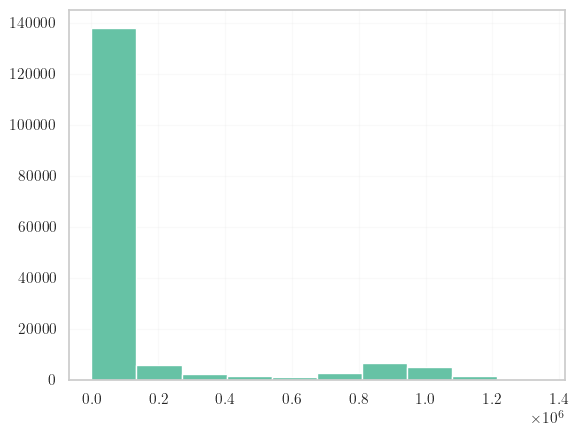

In [14]:
plt.hist(sub_07.tensor.reshape(641, -1).sum(axis=0))

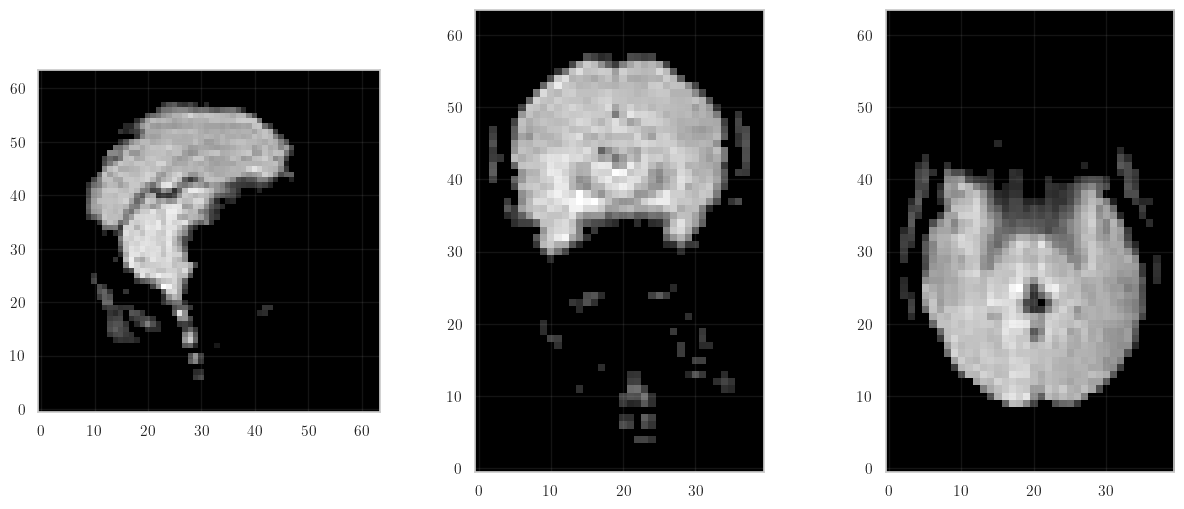

In [15]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.imshow(sub_07.normalized[3][20, :, :].T, cmap='gray', origin='lower')

plt.subplot(1, 3, 2)
plt.imshow(sub_07.normalized[3][:, 30, :].T, cmap='gray', origin="lower")

plt.subplot(1, 3, 3)
plt.imshow(sub_07.normalized[3][:, :, 40].T, cmap='gray', origin="lower")

Распределение значений вокселей

In [7]:
ttensor = sub_07.normalized.reshape(641, -1)

In [9]:
ttensor = ttensor.T

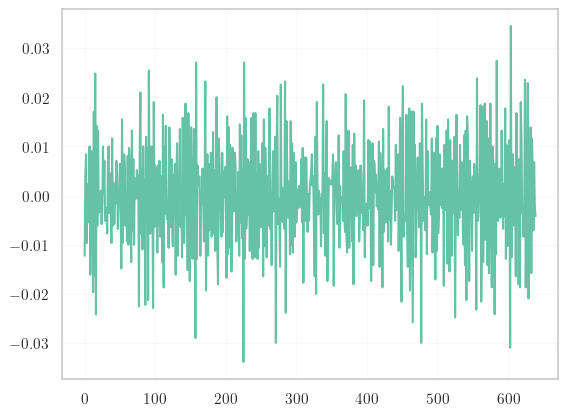

In [43]:
plt.plot(ttensor[42343][1:] - ttensor[42343][:-1])

In [45]:
i = 42343
if ttensor[i].min() != ttensor[i].max():
    print(statsmodels.tsa.stattools.kpss((ttensor[i][1:] - ttensor[i][:-1]), regression='c', nlags=None, store=False))

(0.029291766370530704, 0.1, 21, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\ztimu\AppData\Local\Temp\ipykernel_20012\347643794.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(statsmodels.tsa.stattools.kpss((ttensor[i][1:] - ttensor[i][:-1]), regression='c', nlags=None, store=False))


(array([3212.,   33.,   83.,   48.,   31.,   44.,   83.,  280.,  249.,
          33.]),
 array([0.        , 0.07983197, 0.15966394, 0.23949591, 0.31932789,
        0.39915986, 0.47899183, 0.5588238 , 0.63865577, 0.71848774,
        0.79831971]),
 <BarContainer object of 10 artists>)

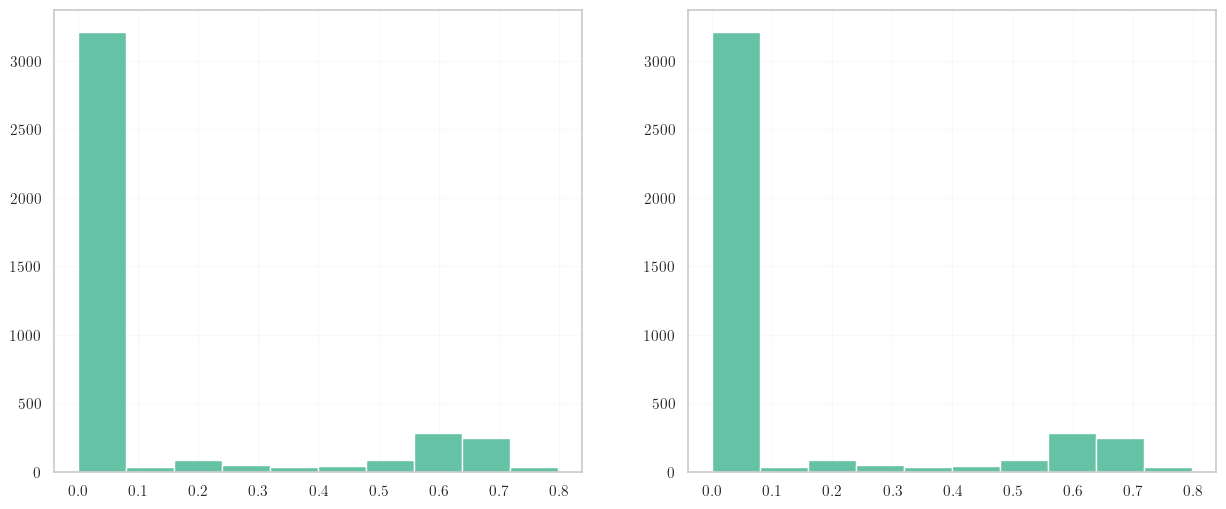

In [16]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.hist(sub_07.normalized[0][25, :, :].T.reshape(-1))
plt.subplot(1, 2, 2)
plt.hist(sub_07.normalized[0][25, :, :].T.reshape(-1)[sub_07.normalized[0][25, :, :].T.reshape(-1) > -3])

### Анализ звуковой дорожки

In [17]:
x, sr = librosa.load(os.path.join(os.getcwd(), "src", "Film stimulus.mp3"), sr=44100)

#### Feature extraction

https://www.sciencedirect.com/science/article/pii/S0003682X19308795

In [18]:
mfcc=librosa.feature.mfcc(y=x, n_mfcc=13)

In [19]:
mfcc.shape

(13, 33642)

Можно выделить музыку и диалог

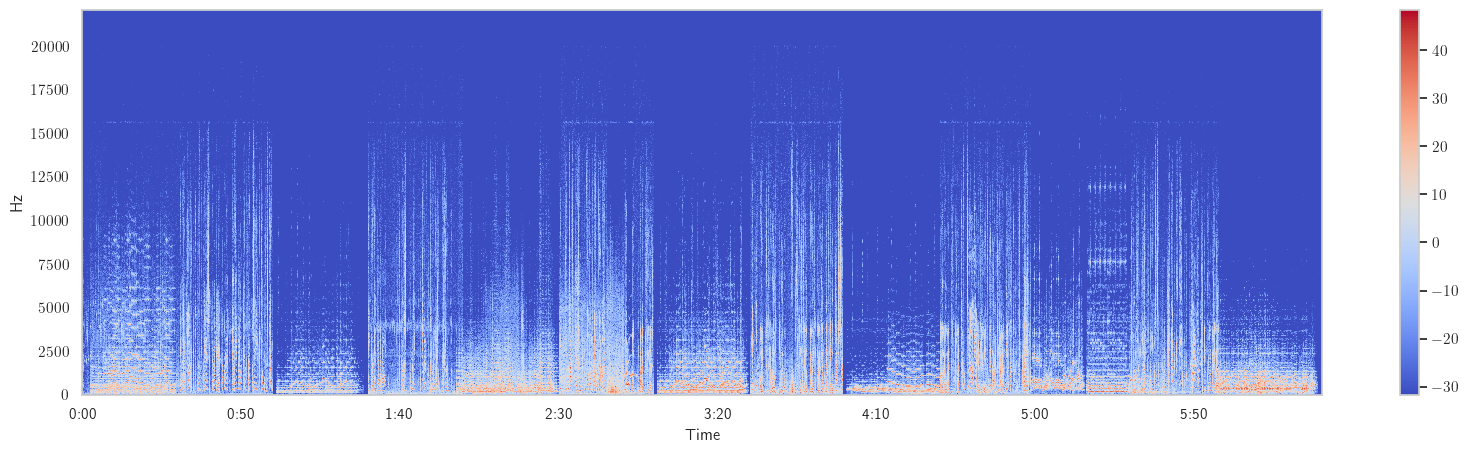

In [20]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(20, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

Давайте масштабируем MFCC так, чтобы каждое измерение коэффициента имело нулевое среднее значение и единичную дисперсию

In [21]:
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
# mfcc = StandardScaler().fit_transform(mfcc)
print(mfcc.mean(axis=1))
print(mfcc.var(axis=1))

[ 0.0000000e+00 -4.0820729e-09 -7.2570185e-09 -4.0820729e-09
 -9.0712732e-10 -3.1749456e-09  4.5356368e-09  5.4427640e-09
 -7.2570185e-09  5.4427640e-09 -8.6177101e-09  0.0000000e+00
  6.6900641e-09]
[0.9999999 1.        1.        1.        1.0000001 1.0000001 1.
 1.        1.        1.        0.9999999 1.0000001 1.       ]


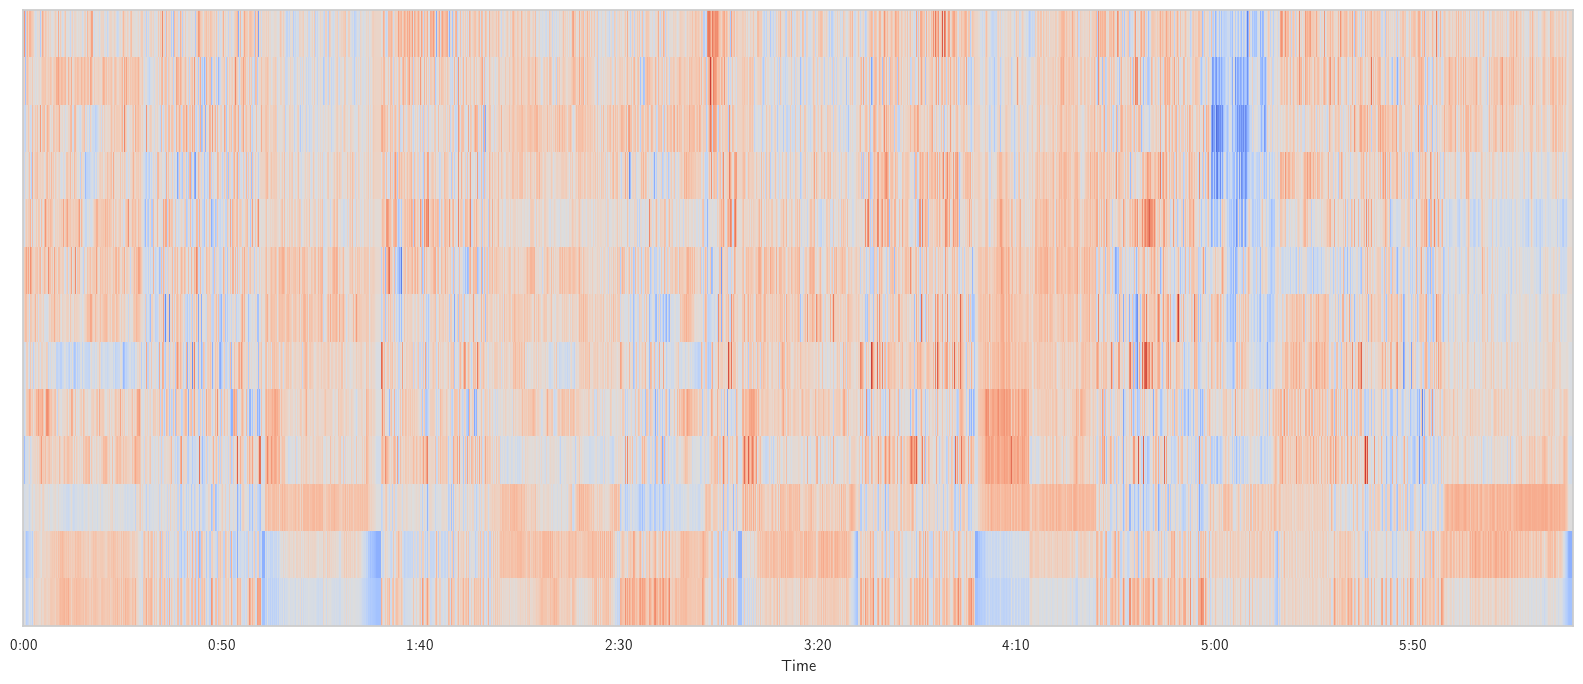

In [22]:
plt.figure(figsize=(20,8))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')

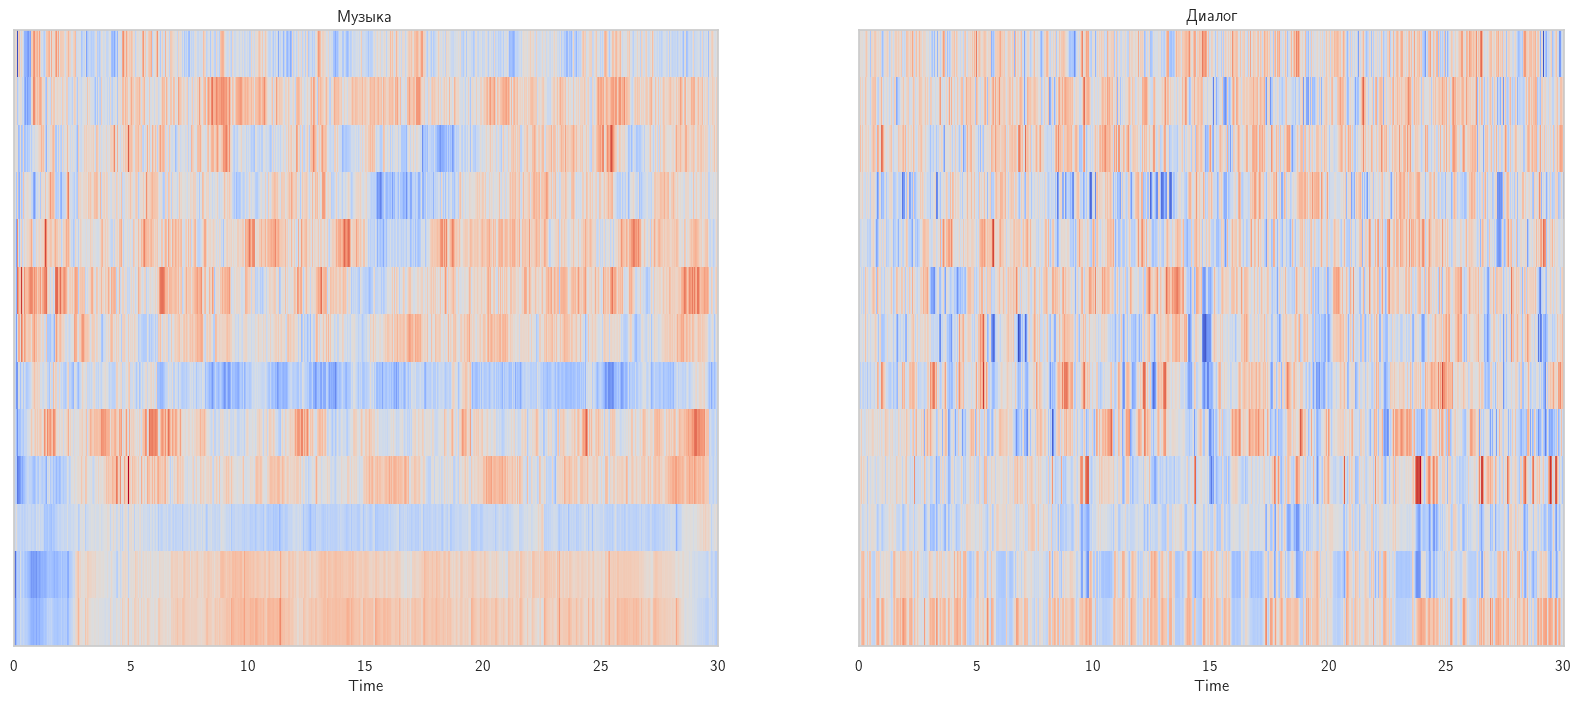

In [23]:
plt.figure(figsize=(20,8))
ax = plt.subplot(1, 2, 1)
librosa.display.specshow(mfcc[:, :int(mfcc.shape[1] / 13)], sr=sr, x_axis='time')
ax.set_title("Музыка")
ax = plt.subplot(1, 2, 2)
librosa.display.specshow(mfcc[:, int(mfcc.shape[1] / 13):int(mfcc.shape[1] * 2 / 13)], sr=sr, x_axis='time')
ax.set_title("Диалог")
plt.show()

In [24]:
X = mfcc.copy().T

### Анализ зависимостей

https://www.sciencedirect.com/science/article/pii/S0165027013003701?via%3Dihub

In [105]:
# https://www.sciencedirect.com/science/article/pii/S0165027013003701?via%3Dihub

def tsdata_to_autocov(X, q):
    from matplotlib import mlab

    if len(X.shape) == 2:
        X = np.expand_dims(X, axis=2)
        [n, m, N] = np.shape(X)
    else:
        [n, m, N] = np.shape(X)
    X = mlab.detrend_mean(X, axis=1)
    G = np.zeros((n, n, (q+1)))

    for k in range(q+1):
        M = N * (m-k)
        G[:,:,k] = np.dot(np.reshape(X[:,k:m,:], (n, M)), np.reshape(X[:,0:m-k,:], (n, M)).conj().T) / M-1
    return G

При dt=5

In [83]:
preprocessor = models.Preprocessor(np.arange(641 - int(641. / 390. * 5)), smoothed, Sub('07'), 5, 1, 1)

(13,) (163840,)


In [84]:
x = np.array(preprocessor.train)[:, 0]

In [85]:
y = np.array(preprocessor.train)[:, 1]

In [86]:
assert(x.shape, y.shape)

In [87]:
print(x.shape, y.shape)

(633,) (633,)


In [88]:
y = np.concatenate(y).reshape(633, 163840)

In [89]:
x = np.concatenate(x).reshape(633, 13)

Некоторые примеры

In [144]:
some_voxel = y[:, 58964]

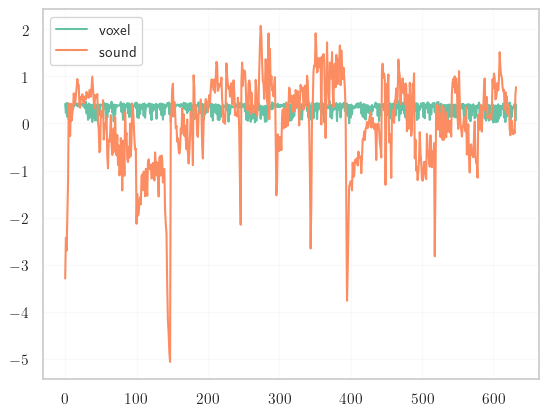

In [145]:
plt.plot(np.arange(some_voxel.shape[0]), some_voxel, label='voxel')
plt.plot(np.arange(some_voxel.shape[0]), x[:, 0], label='sound')
plt.legend()

In [146]:
X = np.concatenate((x, y[:, 58964].reshape(633, 1)), axis=1)

In [365]:
X.shape

(33642, 13)

In [160]:
G = tsdata_to_autocov(X, 2)

In [161]:
len(autocov_to_var(G))

ValueError: operands could not be broadcast together with shapes (632,633) (633,633) 

In [150]:
def autocov_to_var(G):

    [n,m,q1] = G.shape;
    q = q1 - 1
    qn = q * n
    G0 = G[:,:,0]
    # covariance
    GF = np.reshape(G[:,:,1:], (n, qn)).T
    # backward autocov sequence
    GB = np.reshape(np.transpose(G[:,:,1:], (0, 2, 1)), (qn, n))

    # forward  coefficients
    AF = np.zeros([n, qn])
    # backward coefficients (reversed compared with Whittle's treatment)
    AB = np.zeros([n, qn])

    # initialise recursion
    k = 1 # model order
    r = q-k
    kf = np.arange(k*n)
    # forward  indices
    kb = np.arange(r*n, qn)
    # backward indices
    AF[:,kf] = np.dot(GB[kb,:],np.linalg.inv(G0))
    AB[:,kb] = np.dot(GF[kf,:],np.linalg.inv(G0))

    for k in np.arange(2, q+1):

        DF = GB[(r-1)*n+1:r*n,:] - np.dot(AF[:,kf],GB[kb,:])
        VB = G0 - np.dot(AB[:,kb],GB[kb,:])

        AAF = np.dot(DF,np.linalg.inv(VB)); # DF/VB

        DB = GF[(k-1)*n+1:k*n,:] - np.dot(AB[:,kb],GF[kf,:])
        VF = np.dot(G0-AF[:,kf],GF[kf,:])

        AAB = np.dot(DB,np.linalg.inv(VF)); # DB/VF

        AFPREV = AF[:,kf-1]
        ABPREV = AB[:,kb-1]
        r = q-k
        kf = np.arange(1, (np.dot(k, n))+1)
        kb = np.arange(np.dot(r, n)+1, (qn)+1)
        AF[:,kf-1] = np.array(np.hstack((AFPREV-np.dot(AAF, ABPREV), AAF)))
        AB[:,kb-1] = np.array(np.hstack((AAB, ABPREV-np.dot(AAB, AFPREV))))

    SIG = G0-np.dot(AF, GF)
    AF = np.reshape(AF, (n, n, q))
    return [AF, SIG]

In [151]:
def autocov_to_mvgc(G, x, y):

    n = G.shape[0]

    z = np.arange(n)
    z = np.delete(z,[np.array(np.hstack((x, y)))])
    # indices of other variables (to condition out)
    xz = np.array(np.hstack((x, z)))
    xzy = np.array(np.hstack((xz, y)))
    F = 0

    # full regression
    ixgrid1 = np.ix_(xzy,xzy)
    [AF,SIG] = autocov_to_var(G[ixgrid1])

    # reduced regression
    ixgrid2 = np.ix_(xz,xz)
    [AF,SIGR] = autocov_to_var(G[ixgrid2])


    ixgrid3 = np.ix_(x,x)
    F = np.log(np.linalg.det(SIGR[ixgrid3]))-np.log(np.linalg.det(SIG[ixgrid3]))
    return F

In [162]:
F = autocov_to_mvgc(G, np.arange(13), 13)

ValueError: operands could not be broadcast together with shapes (632,633) (633,633) 

In [155]:
F

nan

## Обработка данных

In [4]:
X = get_audio_encoding()

In [5]:
fmri_rate = 641 / 389
audio_mfcc_rate = X.shape[0] / 389

In [6]:
def get_scopes(dt, divide=True):
    N = 641 - np.round(fmri_rate * dt)
    
    if not divide:
        return np.arange(N)
    
    borders = [int(N / 13 * i) for i in range(14)]
    
    music_scope = [np.arange(borders[i], borders[i + 1]) for i in range(0, 14, 2)]
    dialogue_scope = [np.arange(borders[i], borders[i + 1]) for i in range(1, 13, 2)]

    music_scope = np.concatenate(music_scope)
    dialogue_scope = np.concatenate(dialogue_scope)
    
    return music_scope, dialogue_scope

In [7]:
music_scope, dialogue_scope = get_scopes(5)

all_scope = get_scopes(5, divide=False)

In [8]:
sub = Sub('07')

In [9]:
Y = sub.normalized.reshape((641, -1)).numpy()

In [10]:
Y.shape

(641, 163840)

In [11]:
X.shape

(33642, 15)

In [12]:
X_train_music = []
Y_train_music = []
X_train_dialogue = []
Y_train_dialogue = []
X_train_all = []
Y_train_all = []

In [13]:
step = int(np.round(39 * audio_mfcc_rate / fmri_rate)) - int(np.round(38 * audio_mfcc_rate / fmri_rate)) - 3
step

50

In [14]:
for i in music_scope[1:]:
    sound_sample = int(np.round(i * audio_mfcc_rate / fmri_rate))
    fmri_sample = int(np.round(fmri_rate * 5 + i))
    X_train_music.append(X[sound_sample - step : sound_sample].mean(axis=0))
    Y_train_music.append(Y[fmri_sample] - Y[fmri_sample - 1])

for i in dialogue_scope:
    sound_sample = int(np.round(i * audio_mfcc_rate / fmri_rate))
    fmri_sample = int(np.round(fmri_rate * 5 + i))
    X_train_dialogue.append(X[sound_sample - step : sound_sample].mean(axis=0))
    Y_train_dialogue.append(Y[fmri_sample] - Y[fmri_sample - 1])

for i in all_scope[1:]:
    sound_sample = int(np.round(i * audio_mfcc_rate / fmri_rate))
    fmri_sample = int(np.round(fmri_rate * 5 + i))
    X_train_all.append(X[sound_sample - step : sound_sample].mean(axis=0))
    Y_train_all.append(Y[fmri_sample] - Y[fmri_sample - 1])


X_train_music = np.array(X_train_music)
X_train_dialogue = np.array(X_train_dialogue)
X_train_all = np.array(X_train_all)

Y_train_music = np.array(Y_train_music)
Y_train_dialogue = np.array(Y_train_dialogue)
Y_train_all = np.array(Y_train_all)

In [15]:
print(X_train_music.shape, Y_train_music.shape)

(340, 15) (340, 163840)


In [16]:
X_train_music = sm.add_constant(X_train_music)

In [17]:
X_train_dialogue = sm.add_constant(X_train_dialogue)

In [18]:
X_train_all = sm.add_constant(X_train_all)

In [19]:
Y_train_music[:, 0].shape

(340,)

---

## Проверка на гетероскедастичность

In [26]:
from statsmodels.stats.diagnostic import het_breuschpagan

In [416]:
bartlett_p_values = []

for i in tqdm(range(163840)):
    model = sm.OLS(Y_train[:, i], X_train)
    results = model.fit_regularized()

    _, bartlett_p_value, _, _ = het_breuschpagan(results.resid, exog_het=results.model.exog)
    bartlett_p_values.append(bartlett_p_value)

  0%|          | 0/163840 [00:00<?, ?it/s]

In [417]:
(np.array(bartlett_p_values)).shape

(163840,)

In [424]:
np.where(np.array(bartlett_p_values) < 0.0001)

(array([ 18661,  26979,  38303,  38381,  42209,  46870,  49945,  50465,
         50481,  59027,  59028,  59153,  59596,  59659,  66389,  66403,
         66976,  71024,  71060,  79579,  79582,  83476,  87718,  91793,
         91858,  96301,  96557,  99230, 100397, 100461, 103799, 116755,
        116953, 117000, 119979, 120847, 120848, 121098, 124879, 124895,
        124943, 125259, 128787, 128913, 128978, 132883, 132948, 133079,
        136622, 136941], dtype=int64),)

----

## Обучение

In [25]:
from sklearn.linear_model import LinearRegression

In [50]:
pvals

array([0., 0., 0., ..., 0., 0., 0.])

In [99]:
def calculate_mse(y, X, scope, mask):
    deltaY_test_predicted = []
    
    for i in tqdm(range(163840)):
        y_partial = y[:, i]
        model = LinearRegression(fit_intercept=False).fit(X, y_partial)
        deltaY_test_predicted.append(model.predict(X))
        
    Y_true_diff = []

    for i in scope:
        Y_true_diff.append(Y[int(np.round(fmri_rate * 5 + i)) - 1])

    Y_true_diff = np.array(Y_true_diff)

    deltaY_test_predicted = np.array(deltaY_test_predicted)

    Y_test_predicted = deltaY_test_predicted.T + Y_true_diff

    return utils.MSE((Y_train_music + Y_true_diff).reshape(-1)[np.nonzero(mask)], Y_test_predicted.reshape(-1)[np.nonzero(mask)]), utils.MSE((Y_train_music + Y_true_diff).reshape(-1), Y_test_predicted.reshape(-1))

In [100]:
mses = []
corr_mses = []

In [62]:
backup_mses =mses
backup_corr_mses =corr_mses

In [101]:

for dt in [2, 3, 4, 5, 6, 7]:
    X_train_music = []
    Y_train_music = []
    
    music_scope, _ = get_scopes(dt)
    
    for i in music_scope[1:]:
        sound_sample = int(np.round(i * audio_mfcc_rate / fmri_rate))
        fmri_sample = int(np.round(fmri_rate * dt + i))
        X_train_music.append(X[sound_sample - step : sound_sample].mean(axis=0))
        Y_train_music.append(Y[fmri_sample] - Y[fmri_sample - 1])
    
    X_train_music = sm.add_constant(X_train_music)
    
    corr, mse = calculate_mse(np.array(Y_train_music), np.array(X_train_music), music_scope[1:], ((get_temporal_mask(40, 64, 64) + pvals) == 2))
    corr_mses.append(corr)
    mses.append(mse)

NameError: name 'pvals' is not defined

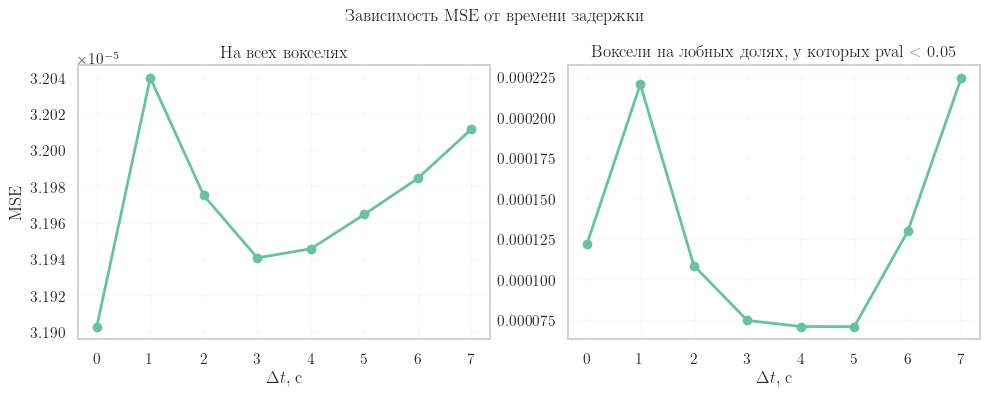

In [133]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle('Зависимость MSE от времени задержки')

ax[0].set_title('На всех вокселях')
ax[0].plot(mses[:-2], marker='o', label=r"MSE")
#ax[0].set_xlabel("Время задержки $\Delta t$, с")
ax[0].set_xlabel("$\Delta t$, с")
ax[0].set_ylabel("MSE")
# ax[0].legend()
ax[0].grid(alpha=0.1)

ax[1].set_title('Воксели на лобных долях, у которых pval < 0.05')
ax[1].plot(corr_mses[:-2], marker='o', label=r"Поправл. MSE")
#ax[1].set_xlabel("Время задержки $\Delta t$, с")
ax[1].set_xlabel("$\Delta t$, с")
#ax[1].set_ylabel("MSE")
# ax[1].legend()
ax[1].grid(alpha=0.1)

plt.tight_layout()
plt.savefig("mse_dt.png", dpi=600)
plt.show()

In [22]:
lin_models_results_music_dummy = []
lin_models_results_dialogue_dummy = []

X_train_dummy_music = np.random.uniform(-1, 1, size=X_train_music.shape)
X_train_dummy_dialogue = np.random.uniform(-1, 1, size=X_train_dialogue.shape)

for i in tqdm(range(163840)):
    y = Y_train_music[:, i]
    model = sm.OLS(y, X_train_dummy_music)
    lin_models_results_music_dummy.append(model.fit(cov_type='HC3'))
    
    y = Y_train_dialogue[:, i]
    model = sm.OLS(y, X_train_dummy_dialogue)
    lin_models_results_dialogue_dummy.append(model.fit(cov_type='HC3'))

  0%|          | 0/163840 [00:00<?, ?it/s]

In [23]:
lin_models_music = []
lin_models_results_music = []

lin_models_dialogue = []
lin_models_results_dialogue = []

for i in tqdm(range(163840)):
    y = Y_train_music[:, i]
    model = sm.OLS(y, X_train_music)
    lin_models_results_music.append(model.fit(cov_type='HC3'))
    lin_models_music.append(model)
    
    y = Y_train_dialogue[:, i]
    model = sm.OLS(y, X_train_dialogue)
    lin_models_results_dialogue.append(model.fit(cov_type='HC3'))
    lin_models_dialogue.append(model)

  0%|          | 0/163840 [00:00<?, ?it/s]

In [24]:
Y_true_diff_music = []

for i in tqdm(music_scope[1:]):
    Y_true_diff_music.append(Y[int(np.round(fmri_rate * 5 + i)) - 1])
    
Y_true_diff_music = np.array(Y_true_diff_music)

deltaY_test_predicted = np.array([lin_models_results_music[i].predict(X_train_music) for i in tqdm(range(163840))])

Y_test_predicted_music = deltaY_test_predicted.T + Y_true_diff_music

print(utils.MSE((Y_train_music + Y_true_diff_music).reshape(-1), Y_test_predicted_music.reshape(-1)))

Y_true_music = Y_train_music + Y_true_diff_music

  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/163840 [00:00<?, ?it/s]

3.196455097154672e-05


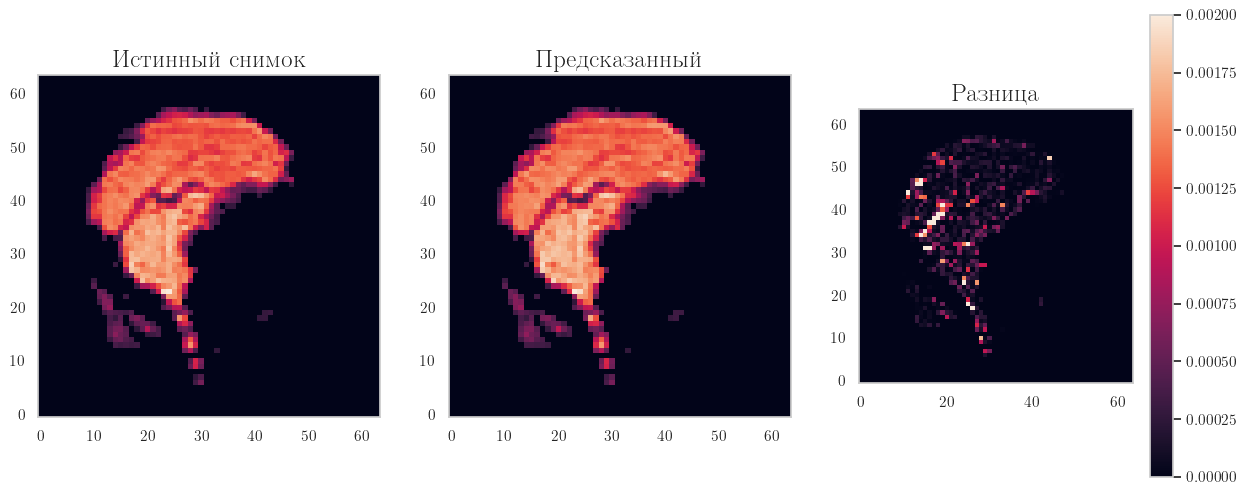

In [84]:
plt.figure(figsize=(15, 6))
ax = plt.subplot(1, 3, 1)
plt.imshow(Y_true_music[-40].reshape(40, 64, 64)[20, :, :].T, origin='lower')
ax.set_title('Истинный снимок', fontsize=18)

ax = plt.subplot(1, 3, 2)
plt.imshow(Y_test_predicted[-40].reshape(40, 64, 64)[20, :, :].T, origin='lower')
ax.set_title('Предсказанный', fontsize=18)

diff = np.abs(Y_true_music[-40].reshape(40, 64, 64)[20, :, :].T - Y_test_predicted[-40].reshape(40, 64, 64)[20, :, :].T)**2

diff[diff > 0.002] = 0.002

ax = plt.subplot(1, 3, 3)
plt.imshow(diff, origin='lower')
ax.set_title('Разница', fontsize=18)
plt.colorbar()
plt.savefig('example.png', dpi=600)

plt.show()

In [25]:
Y_true_diff = []

for i in tqdm(dialogue_scope):
    Y_true_diff.append(Y[int(np.round(fmri_rate * 5 + i)) - 1])
    
Y_true_diff = np.array(Y_true_diff)

deltaY_test_predicted = np.array([lin_models_results_dialogue[i].predict(X_train_dialogue) for i in tqdm(range(163840))])

Y_test_predicted = deltaY_test_predicted.T + Y_true_diff

print(utils.MSE((Y_train_dialogue + Y_true_diff).reshape(-1), Y_test_predicted.reshape(-1)))

Y_true_dialogue = Y_train_dialogue + Y_true_diff

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/163840 [00:00<?, ?it/s]

3.098900362443859e-05


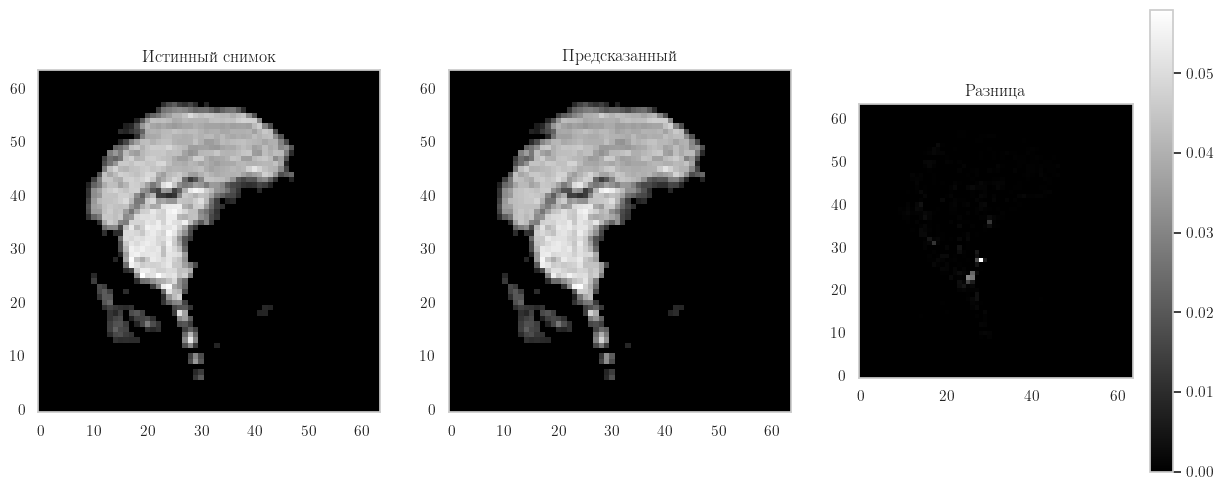

In [64]:
plt.figure(figsize=(15, 6))
ax = plt.subplot(1, 3, 1)
plt.imshow(Y_true[-25].reshape(40, 64, 64)[20, :, :].T, cmap='gray', origin='lower')
ax.set_title('Истинный снимок')

ax = plt.subplot(1, 3, 2)
plt.imshow(Y_test_predicted[-25].reshape(40, 64, 64)[20, :, :].T, cmap='gray', origin='lower')
ax.set_title('Предсказанный')

diff = np.abs(Y_true[-25].reshape(40, 64, 64)[20, :, :].T - Y_test_predicted[-10].reshape(40, 64, 64)[20, :, :].T)**2

diff[diff > 1] = 0

ax = plt.subplot(1, 3, 3)
plt.imshow(diff, cmap='gray', origin='lower')
ax.set_title('Разница')
plt.colorbar()
plt.savefig('example.png', dpi=600)
plt.show()

## Корректность модели

In [34]:
X_train_dialogue[-41].shape

(16,)

In [26]:
Y_test_predicted_recursive = [Y_true_dialogue[-41]]
Y_test_predicted_recursive_dummy = [Y_true_dialogue[-41]]
for i in tqdm(range(-40, 0, 1)):
    Y_test_predicted_recursive.append(Y_test_predicted_recursive[-1] + 
        np.array([lin_models_results_dialogue[j].predict(X_train_dialogue[i]) for j in range(163840)]).T)
    
    Y_test_predicted_recursive_dummy.append(Y_test_predicted_recursive_dummy[-1] + 
        np.array([lin_models_results_dialogue_dummy[j].predict(X_train_dialogue[i]) for j in range(163840)]).T)

  0%|          | 0/40 [00:00<?, ?it/s]

In [27]:
Y_test_predicted_recursive_music = [Y_true_music[-41]]
Y_test_predicted_recursive_dummy_music = [Y_true_music[-41]]
for i in tqdm(range(-40, 0, 1)):
    Y_test_predicted_recursive_music.append(Y_test_predicted_recursive_music[-1] + 
        np.array([lin_models_results_music[j].predict(X_train_music[i]) for j in range(163840)]).T)
    
    Y_test_predicted_recursive_dummy_music.append(Y_test_predicted_recursive_dummy_music[-1] + 
        np.array([lin_models_results_music_dummy[j].predict(X_train_music[i]) for j in range(163840)]).T)

  0%|          | 0/40 [00:00<?, ?it/s]

In [28]:
Y_test_predicted_recursive = np.concatenate([Y_test_predicted_recursive[i].reshape(-1) for i in range(41)]).reshape(41, -1)
Y_test_predicted_recursive_dummy = np.concatenate([Y_test_predicted_recursive_dummy[i].reshape(-1) for i in range(41)]).reshape(41, -1)

In [29]:
Y_test_predicted_recursive_music = np.concatenate([Y_test_predicted_recursive_music[i].reshape(-1) for i in range(41)]).reshape(41, -1)
Y_test_predicted_recursive_dummy_music = np.concatenate([Y_test_predicted_recursive_dummy_music[i].reshape(-1) for i in range(41)]).reshape(41, -1)

In [30]:
from scipy.optimize import curve_fit

In [32]:
def func(x, b, c, d):
    return  b * x**2 + c * x + d

def fit_curve(x, y):
    popt, _ = curve_fit(func, x, y)
    return func(x, *popt)


mse_model = utils.MSE(Y_test_predicted_recursive[1:], Y_true_dialogue[-40:])
mse_dummy = utils.MSE(Y_test_predicted_recursive_dummy[1:], Y_true_dialogue[-40:])

mse_model_music = utils.MSE(Y_test_predicted_recursive_music[1:], Y_true_music[-40:])
mse_dummy_music = utils.MSE(Y_test_predicted_recursive_dummy_music[1:], Y_true_music[-40:])

mse_model_smooth = fit_curve(np.arange(len(Y_true_dialogue[-40:])), mse_model)
mse_dummy_smooth = fit_curve(np.arange(len(Y_true_dialogue[-40:])), mse_dummy)

mse_model_music_smooth = fit_curve(np.arange(len(Y_true_music[-40:])), mse_model_music)
mse_dummy_music_smooth = fit_curve(np.arange(len(Y_true_music[-40:])), mse_dummy_music)

x_smooth = np.linspace(0, len(Y_true_music[-40:]), 40)

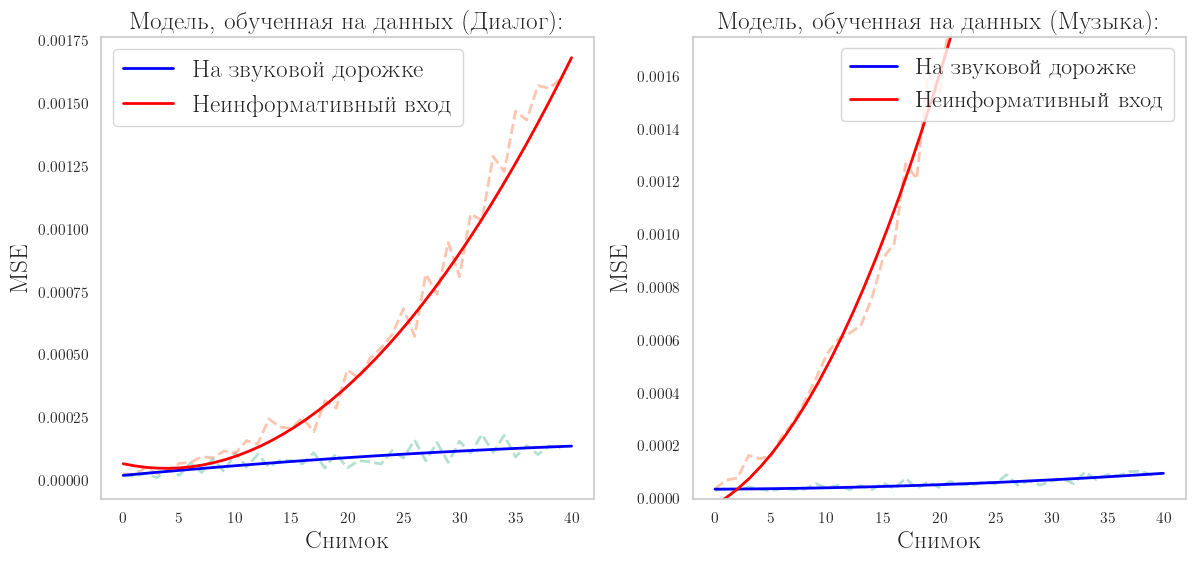

In [77]:

plt.figure(figsize=(14, 6))
# plt.suptitle('Зависимость MSE от номера снимка в рекурсивной стратегии')

plt.subplot(1, 2, 1)
plt.plot(np.arange(len(Y_true_dialogue[-40:])), mse_model, '--', alpha=0.5)
plt.plot(np.arange(len(Y_true_dialogue[-40:])), mse_dummy, '--', alpha=0.5)
plt.plot(x_smooth, mse_model_smooth, label='На звуковой дорожке', lw=2, c='b')
plt.plot(x_smooth, mse_dummy_smooth, label='Неинформативный вход', lw=2, c='r')

plt.ylabel('MSE', fontsize=18)
plt.xlabel('Снимок', fontsize=18)
plt.title('Модель, обученная на данных (Диалог):', fontsize=18)

plt.legend(prop={'size': 18})

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(Y_true_music[-40:])), mse_model_music, '--', alpha=0.5)
plt.plot(np.arange(len(Y_true_music[-40:])), mse_dummy_music, '--', alpha=0.5)
plt.plot(x_smooth, mse_model_music_smooth, label='На звуковой дорожке', lw=2, c='b')
plt.plot(x_smooth, mse_dummy_music_smooth, label='Неинформативный вход', lw=2, c='r')

plt.ylabel('MSE', fontsize=18)
plt.xlabel('Снимок', fontsize=18)
plt.title('Модель, обученная на данных (Музыка):', fontsize=18, weight='bold')
plt.legend(prop={'size': 17, 'weight':'bold'})
plt.ylim(0, 0.00175)
plt.savefig('recursive.png', dpi=600)
plt.show()

---

## Распределения весов

In [85]:
from statsmodels.stats.multitest import multipletests

In [86]:
pvalues = []

for i in tqdm(range(163840)):
    pvalues.append(lin_models_results_music[i].pvalues)

  0%|          | 0/163840 [00:00<?, ?it/s]

In [143]:
lin_models_results_music[58964].params[1:]

array([ 0.64853626, -0.535128  ,  0.47374415, -0.23182821,  0.17785224,
       -0.15171506,  0.11192519, -0.12338788,  0.14756345, -0.10951247,
        0.07654128, -0.04021102,  0.03356844, -0.0516192 ,  0.01588485])

In [91]:
coeffs = []
all_coeffs = [[] for _ in range(16)]

for i in tqdm(range(163840)):
    coeffs.append(lin_models_results_music[i].params[np.where(pvalues[i] < 0.1)])
    
    for j in range(1, 16):
        if pvalues[i][j] < 0.1:
            all_coeffs[j].append(lin_models_results_music[i].params[j])

coeffs = np.concatenate(coeffs)
# all_coeffs = np.concatenate(all_coeffs)

  0%|          | 0/163840 [00:00<?, ?it/s]

In [92]:
counts = [len(all_coeffs[i]) for i in range(1, 16)]

colors = [(1-c / max(counts), c / max(counts), 0) for c in counts]

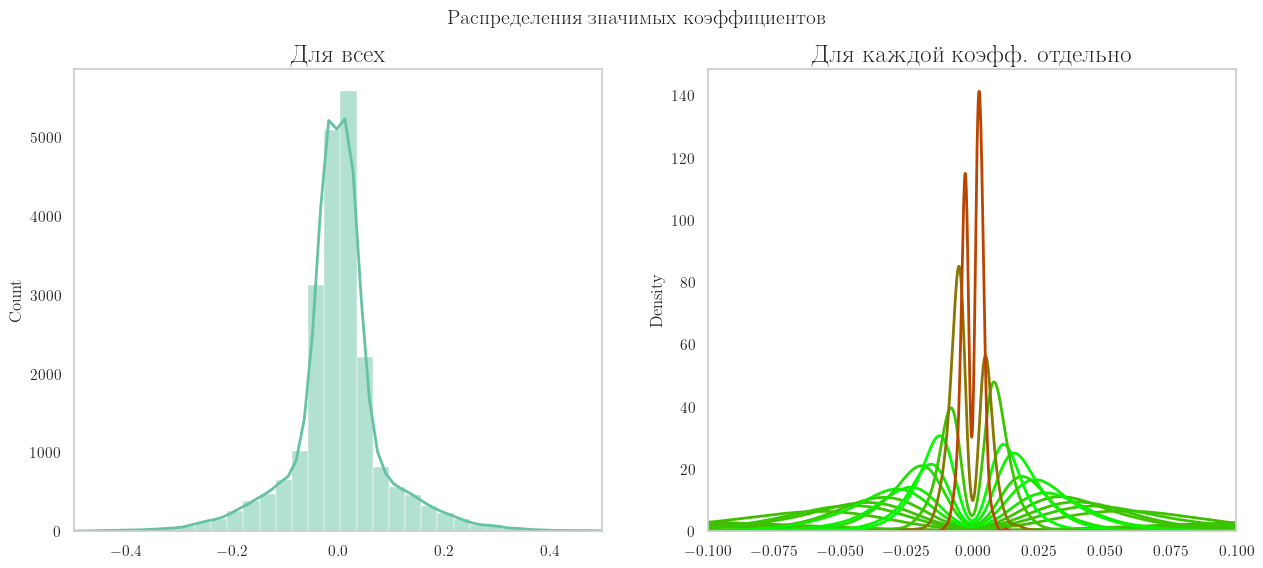

In [97]:
plt.figure(figsize=(15, 6))
plt.suptitle('Распределения значимых коэффициентов', fontsize=15)

plt.subplot(1, 2, 1)
plt.title('Для всех', fontsize=18)
sns.histplot(coeffs, bins=100, kde=True)
plt.xlim(-0.5, 0.5)
plt.subplot(1, 2, 2)
plt.title('Для каждой коэфф. отдельно', fontsize=18)
for i in range(1, 16):
    sns.kdeplot(all_coeffs[i], color=colors[i-1])
plt.xlim(-0.1, 0.1)
plt.savefig('model_weights_distribution.png', dpi=600)
plt.show()

---

## Влияние задержки



In [1]:
def get_temporal_mask(d1, d2, d3):
    mask1 = np.ones((d1, d2, d3))
    mask1.T[2 * d3//3:, :, :] = 0
    mask1.T[:d3//2, :, :] = 0
    mask1.T[:,:d2//3, :] = 0
    mask1.T[:,2 * d2//3 :, :] = 0
    mask1.T[:,:, :d1//6] = 0
    mask1.T[:,:, -d1//6:] = 0
    mask1.T[:,:, d1//3:-d1//3] = 0
    return mask1.reshape(-1)

In [28]:
from sklearn import linear_model

In [31]:
mses = []
adj_mses = []
mask = get_temporal_mask(40, 64, 64)
for dt in tqdm(range(1, 10)):
    music_scope, dialogue_scope = get_scopes(dt)
    
    X_train = []
    Y_train = []
    
    for i in music_scope[1:]:
        sound_sample = int(np.round(i * audio_mfcc_rate / fmri_rate))
        fmri_sample = int(np.round(fmri_rate * dt + i))
        X_train.append(X[sound_sample - 10 : sound_sample].mean(axis=0))
        Y_train.append(Y[fmri_sample] - Y[fmri_sample - 1])

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_train = sm.add_constant(X_train)
    
    deltaY_test_predicted = []
    
    for i in tqdm(range(163840)):
        y = Y_train[:, i]
        model = linear_model.LinearRegression()
        model.fit(X_train, y)
        deltaY_test_predicted.append(model.predict(X_train))
        
    deltaY_test_predicted = np.array(deltaY_test_predicted)
    
    Y_true_diff = []

    for i in music_scope[1:]:
        Y_true_diff.append(Y[int(np.round(fmri_rate * dt + i)) - 1])

    Y_true_diff = np.array(Y_true_diff)

    Y_test_predicted = deltaY_test_predicted.T + Y_true_diff
    
    mses.append(utils.MSE((Y_train + Y_true_diff).reshape(-1), Y_test_predicted.reshape(-1)))
    adj_mses.append(utils.MSE((Y_train + Y_true_diff).reshape(-1)[np.nonzero(mask)],
                              Y_test_predicted.reshape(-1)[np.nonzero(mask)]))

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/163840 [00:00<?, ?it/s]

  0%|          | 0/163840 [00:00<?, ?it/s]

  0%|          | 0/163840 [00:00<?, ?it/s]

  0%|          | 0/163840 [00:00<?, ?it/s]

  0%|          | 0/163840 [00:00<?, ?it/s]

  0%|          | 0/163840 [00:00<?, ?it/s]

  0%|          | 0/163840 [00:00<?, ?it/s]

  0%|          | 0/163840 [00:00<?, ?it/s]

  0%|          | 0/163840 [00:00<?, ?it/s]

In [ ]:
Y_true_diff = []

for i in tqdm(music_scope[1:]):
    Y_true_diff.append(Y[int(np.round(fmri_rate * 5 + i)) - 1])
    
Y_true_diff = np.array(Y_true_diff)

deltaY_test_predicted = np.array([lin_models_results_music[i].predict(X_train_music) for i in tqdm(range(163840))])

Y_test_predicted = deltaY_test_predicted.T + Y_true_diff

print(utils.MSE((Y_train_music + Y_true_diff).reshape(-1), Y_test_predicted.reshape(-1)))

In [18]:
print(true)

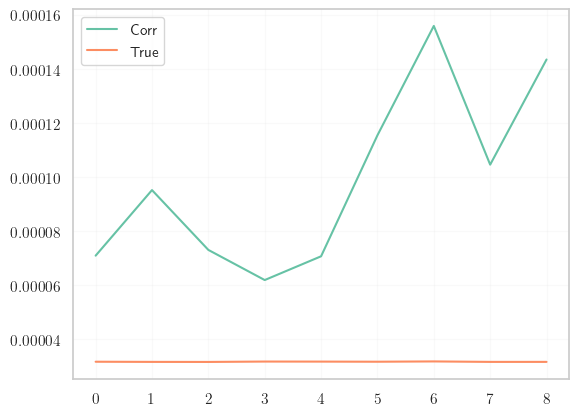

In [32]:
plt.plot(adj_mses, label='Corr')
plt.plot(mses, label='True')
plt.legend()
plt.show()

---

## Найдем пиксели которые реагируют на изменения звука через ANOVA

In [148]:
Y_train_music[-40:][:, 0].shape

(40,)

In [144]:
music_means = Y_train_music[-40:].mean(axis=0)
music_means.shape

(163840,)

In [145]:
dialogue_means = Y_train_dialogue[-40:].mean(axis=0)
dialogue_means.shape

(163840,)

In [170]:
pvals = np.array([sps.mannwhitneyu(Y_train_music[-40:][:, i], Y_train_dialogue[-40:][:, i])[1] for i in tqdm(range(163840))])

  0%|          | 0/163840 [00:00<?, ?it/s]

(array([2.00000e+00, 2.00000e+01, 8.10000e+01, 2.24000e+02, 6.30000e+02,
        1.51000e+03, 2.88500e+03, 4.34600e+03, 5.82100e+03, 1.48321e+05]),
 array([0.17028292, 0.25325463, 0.33622634, 0.41919805, 0.50216975,
        0.58514146, 0.66811317, 0.75108488, 0.83405658, 0.91702829,
        1.        ]),
 <BarContainer object of 10 artists>)

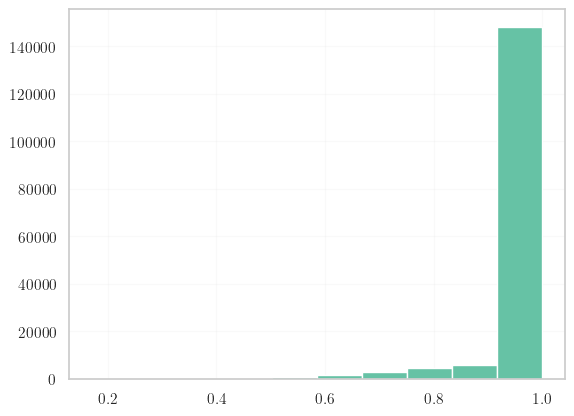

In [181]:
plt.hist(pvals)

In [12]:
import statsmodels

In [172]:
pvals_corrected = statsmodels.stats.multitest.multipletests(pvals)[1]

In [168]:
sps.ttest_rel(Y_train_music[-40:][:, 0], Y_train_dialogue[-40:][:, 0])

TtestResult(statistic=nan, pvalue=nan, df=39)

In [193]:
(pvals < 0.4).mean()

0.000469970703125

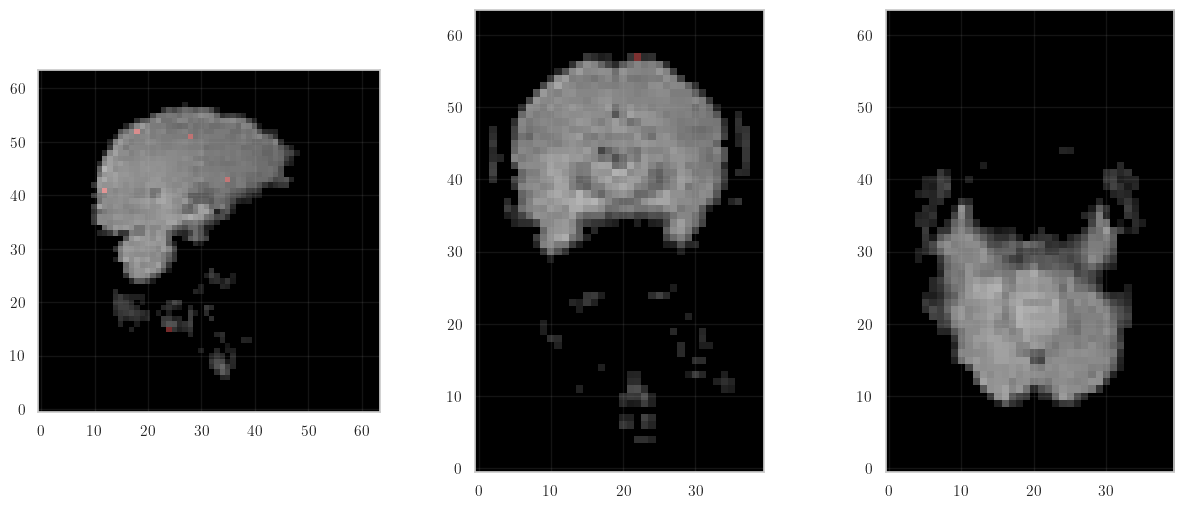

In [194]:
plt.figure(figsize=(15, 6))
cmap = colors.ListedColormap(['black', 'red'])

plt.subplot(1, 3, 1)
plt.imshow(sub.normalized[3][14, :, :].T, cmap='gray', origin='lower')
plt.imshow((pvals < 0.4).reshape(40, 64, 64)[14, :, :].T, cmap=cmap, origin="lower", alpha=0.3)

plt.subplot(1, 3, 2)
plt.imshow(sub.normalized[3][:, 30, :].T, cmap='gray', origin="lower")
plt.imshow((pvals < 0.4).reshape(40, 64, 64)[:, 30, :].T, cmap=cmap, origin="lower", alpha=0.3)

plt.subplot(1, 3, 3)
plt.imshow(sub.normalized[3][:, :, 35].T, cmap='gray', origin="lower")
plt.imshow((pvals < 0.4).reshape(40, 64, 64)[:, :, 35].T, cmap=cmap, origin="lower", alpha=0.3)

---

In [201]:
r_squared = []
fpvalue = []

for i in tqdm(range(163840)):
    fpvalue.append(lin_models_results[i].f_pvalue)
    r_squared.append(lin_models_results[i].rsquared_adj)

  0%|          | 0/163840 [00:00<?, ?it/s]

In [202]:
r_squared = np.array(r_squared)
fpvalue = np.array(fpvalue)

In [203]:
(fpvalue < 0.05).sum()

406

<Axes: ylabel='Density'>

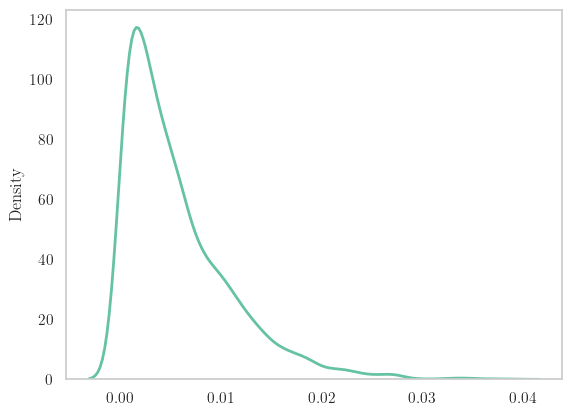

In [216]:
sns.kdeplot(r_squared[r_squared > 0])

In [211]:
threshold = 0.005

In [212]:
np.where(r_squared > threshold)

(array([  5188,   9092,   9413, ..., 140910, 141866, 145066], dtype=int64),)

У некоторых вокселей присутствует линейный тренд???

In [435]:
heteroscedastic_voxel = 71060

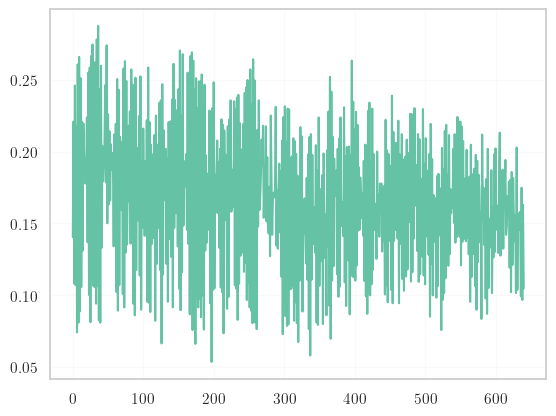

In [116]:
plt.plot(Y[:, 71060])

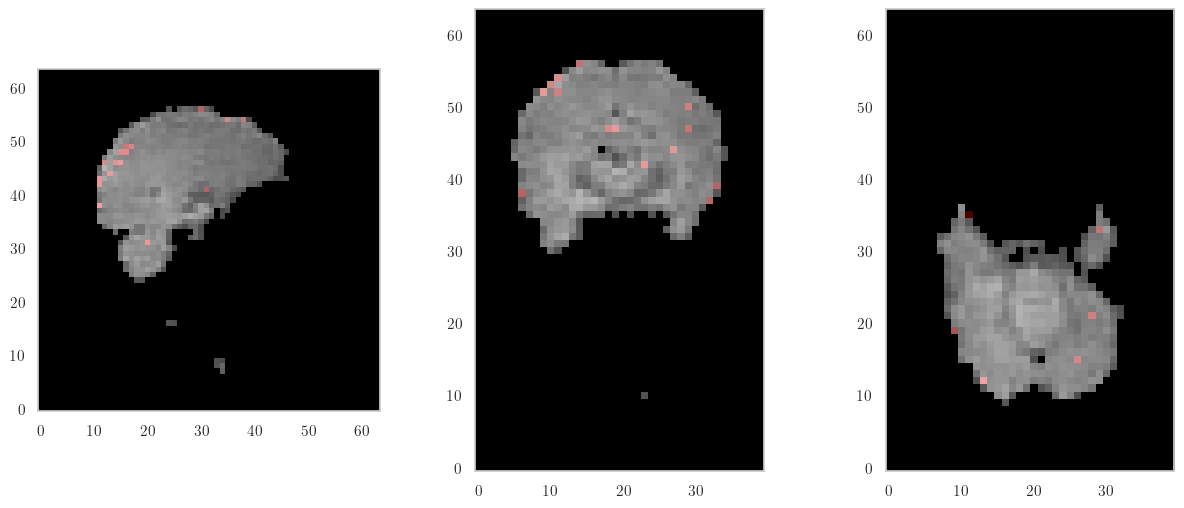

In [215]:
plt.figure(figsize=(15, 6))
cmap = colors.ListedColormap(['black', 'red'])

plt.subplot(1, 3, 1)
plt.imshow(sub.normalized[3][14, :, :].T, cmap='gray', origin='lower')
plt.imshow((fpvalue < 0.05).reshape(40, 64, 64)[14, :, :].T, cmap=cmap, origin="lower", alpha=0.3)

plt.subplot(1, 3, 2)
plt.imshow(sub.normalized[3][:, 30, :].T, cmap='gray', origin="lower")
plt.imshow((fpvalue < 0.05).reshape(40, 64, 64)[:, 30, :].T, cmap=cmap, origin="lower", alpha=0.3)

plt.subplot(1, 3, 3)
plt.imshow(sub.normalized[3][:, :, 35].T, cmap='gray', origin="lower")
plt.imshow((fpvalue < 0.05).reshape(40, 64, 64)[:, :, 35].T, cmap=cmap, origin="lower", alpha=0.3)


In [136]:
assert(smoothed.shape[1] == 13)

In [138]:
lindelta = LinearDeltaModel(all_scope, smoothed, sub, dt=5, coef=1, alpha=1000)

(13,) (163840,)
(442, 13) (163840, 442) (189, 13) (163840, 189)


In [139]:
lindelta.fit()

In [140]:
lindelta.predict()

In [141]:
y_pred, y_true = lindelta.evaluate_recursive()

В предположении continuous теста


# Все

In [142]:
lindelta_music.deltaY_test_predicted.shape

(163840, 102)

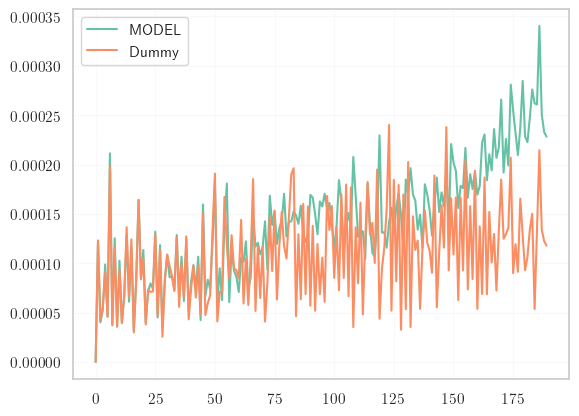

In [150]:
plt.plot(np.arange(len(y_true)), utils.MSE(y_pred, y_true), label='MODEL')
plt.plot(np.arange(len(y_true_dummy)), utils.MSE(y_pred_dummy, y_true), label='Dummy')
# plt.plot(np.arange(len(lindelta_music.Y_test_predicted.T)), utils.MSE(lindelta_music.Y_test_predicted.T, y_true[1:]), label='Not recursive')
# plt.plot(np.arange(len(lindelta_music_dummy.Y_test_predicted.T)),
#          utils.MSE(lindelta_music_dummy.Y_test_predicted.T, y_true[1:]), label='Not recursive Dummy')

plt.legend()
plt.show()

In [151]:
visualizer=Visualizer(lindelta_music)

In [98]:
def get_temporal_mask(d1, d2, d3):
    mask1 = np.ones((d1, d2, d3))
    mask1.T[2 * d3//3:, :, :] = 0
    mask1.T[:d3//2, :, :] = 0
    mask1.T[:,:d2//3, :] = 0
    mask1.T[:,2 * d2//3 :, :] = 0
    mask1.T[:,:, :d1//6] = 0
    mask1.T[:,:, -d1//6:] = 0
    mask1.T[:,:, d1//3:-d1//3] = 0
    return mask1.reshape(-1)

In [153]:
d1, d2, d3 = lindelta_music._d1, lindelta_music._d2, lindelta_music._d3

mask1_temporal = get_temporal_mask(d1, d2, d3)

TEST


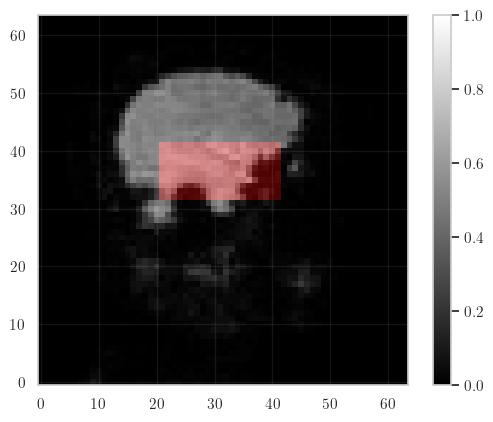

In [154]:
visualizer.show_scan_slices(50, 0, 10, mask1_lobnaya.reshape(d1, d2, d3))

TEST


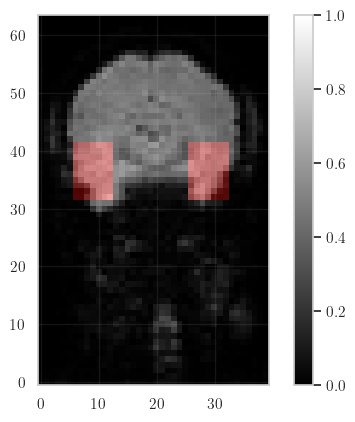

In [119]:
visualizer.show_scan_slices(50, 1, 30, mask1_lobnaya.reshape(d1, d2, d3))

TEST


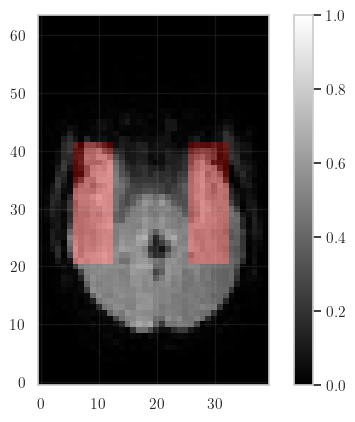

In [120]:
visualizer.show_scan_slices(50, 2, 40, mask1_lobnaya.reshape(d1, d2, d3))

### Корректность моделей

Гипотеза

Звук не влияет на предсказание

Пусть заменим звук на пустоту

In [144]:
smoothed.shape

(1526, 13)

In [145]:
dummy = np.random.uniform(-1, 1, size=(1526, 13))
# dummy = np.zeros(smoothed.shape)
print(dummy.shape)

(1526, 13)


In [146]:
lindelta_music_dummy = LinearDeltaModel(all_scope, dummy, sub, dt=5, coef=1, alpha=1000)

(13,) (163840,)
(442, 13) (163840, 442) (189, 13) (163840, 189)


In [147]:
lindelta_music_dummy.train[0][0]

array([ 0.09357825, -0.5519325 ,  0.15501078, -0.60517557,  0.50986186,
        0.61230547, -0.72120256, -0.00240208,  0.46528248,  0.2758433 ,
       -0.72049521, -0.91579655,  0.36825575])

In [148]:
lindelta_music_dummy.fit()
lindelta_music_dummy.predict()

In [149]:
y_pred_dummy, y_true_dummy = lindelta_music_dummy.evaluate_recursive()

В предположении continuous теста


In [35]:
dummy = np.zeros(smoothed.shape)

In [36]:
lindelta_music_dummy_zero = LinearDeltaModel(music_scope, dummy, sub, dt=5, coef=1, alpha=1000)

(13,) (163840,)
(237, 13) (163840, 237) (102, 13) (163840, 102)


In [37]:
lindelta_music_dummy_zero.fit()
lindelta_music_dummy_zero.predict()

In [43]:
y_pred_dummy_zero, y_true_dummy_zero = lindelta_music_dummy_zero.evaluate_recursive()

В предположении continuous теста


In [43]:
preprocessor = models.Preprocessor(np.arange(641 - int(641. / 390. * 5)), smoothed, Sub('07'), 5, 1, 1)

(13,) (163840,)


In [44]:
train_data = np.array(preprocessor.train)[:, 0]

In [49]:
len(train_data)

633

### Статистический подход

In [212]:
fstatistics_pvalue = np.array(fstatistics_pvalue)

In [213]:
fstatistics_pvalue_decisive = fstatistics_pvalue < 0.05

In [218]:
r_squared = []
r_squared_adj = []


for i in tqdm(range(163840)):
    r_squared.append(lin_models[i].rsquared)
    r_squared_adj.append(lin_models[i].rsquared_adj)    

  0%|          | 0/163840 [00:00<?, ?it/s]

In [56]:
significant_coef_cnt = []


for i in tqdm(range(163840)):
    significant_coef_cnt.append((lin_models[i].pvalues < 0.05).sum())

  0%|          | 0/163840 [00:00<?, ?it/s]

In [57]:
significant_coef_cnt = np.array(significant_coef_cnt)

In [74]:
significant_coef_cnt_decisive = significant_coef_cnt > 3

<Axes: ylabel='Density'>

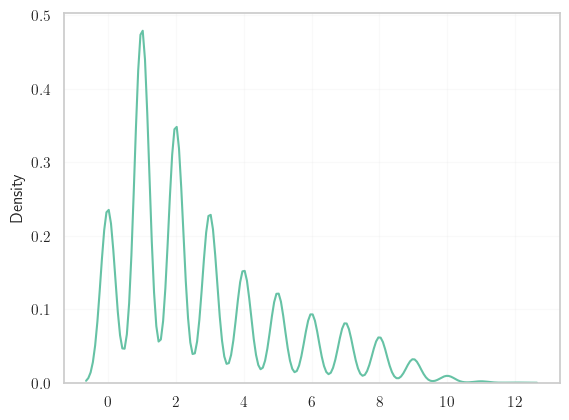

In [59]:
sns.kdeplot(significant_coef_cnt, label='signicant coefss')

In [226]:
r_squared_decisive = np.array(r_squared) > 0.4
r_squared_adj_decisive = np.array(r_squared_adj) > 0.4

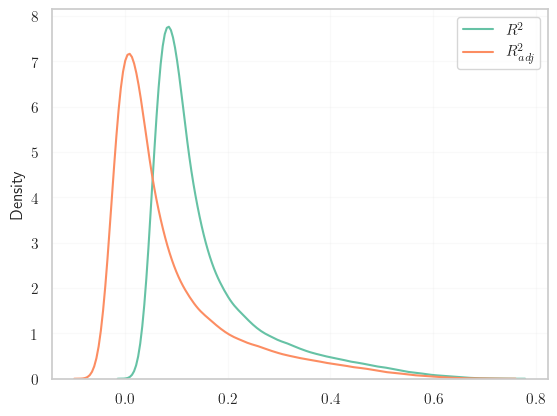

In [222]:
sns.kdeplot(r_squared, label='$R^2$')
sns.kdeplot(r_squared_adj, label='$R_{adj}^2$')

plt.legend()

In [196]:
r = scipy.stats.f.rvs(240, 20, size=1000)

<Axes: ylabel='Density'>

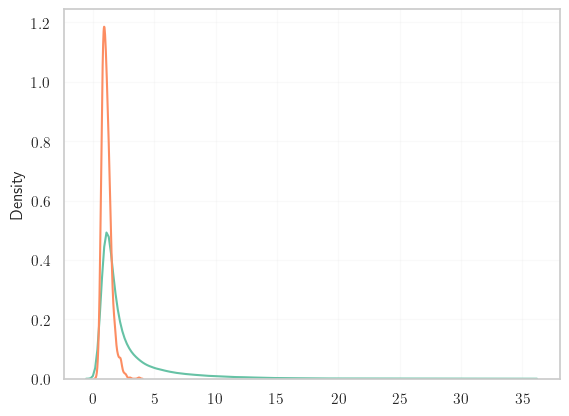

In [207]:
sns.kdeplot(fstatistics)
sns.kdeplot(r)

In [69]:
visualizer = Visualizer(lindelta_music)

TEST


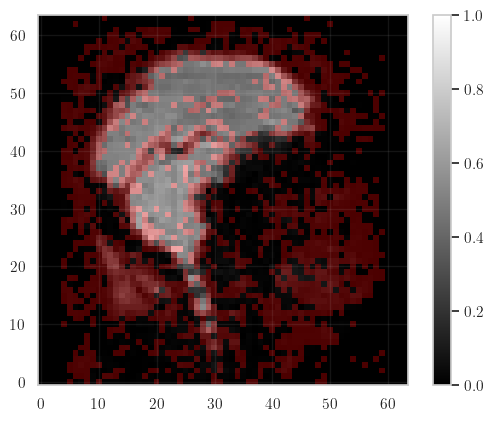

PREDICTED


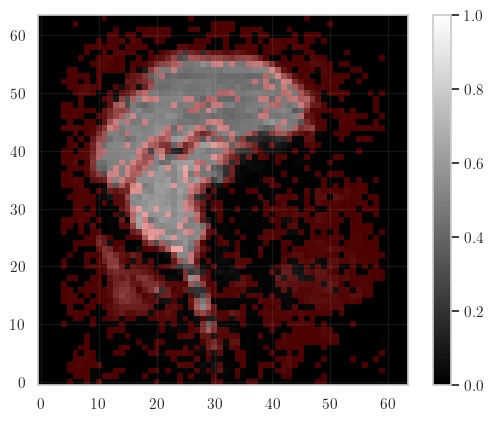

DIFFERENCE


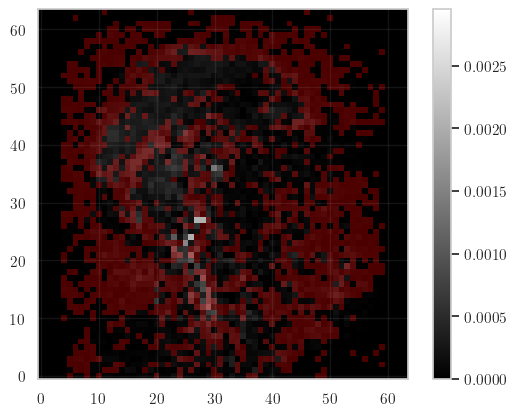

In [75]:
visualizer.show_scan_slices(50, 0, 20, significant_coef_cnt_decisive.reshape(lindelta_music.d1, lindelta_music.d2, lindelta_music.d3))

### Тест Гренджера

In [110]:
x, sr = librosa.load(os.path.join(os.getcwd(), "src", "Film stimulus.mp3"), sr=2000)

In [111]:
X.shape

(33642, 15)

In [112]:
x.shape

(781154,)

In [113]:
audio_mfcc_rate = x.shape[0] / 389

In [115]:
X_truncated = []
Y_truncated = []

for i in all_scope[1:]:
    sound_sample = int(np.round(i * audio_mfcc_rate / fmri_rate))
    fmri_sample = int(np.round(fmri_rate * 5 + i))
    X_truncated.append(np.max(np.abs(x[sound_sample - 100 : sound_sample]), axis=0))
    Y_truncated.append(Y[fmri_sample])

X_truncated = np.array(X_truncated)
Y_truncated = np.array(Y_truncated)

MemoryError: Unable to allocate 790. MiB for an array with shape (632, 163840) and data type float64

In [17]:
301 * audio_mfcc_rate / fmri_rate - 300 * audio_mfcc_rate / fmri_rate

2437.297971918946

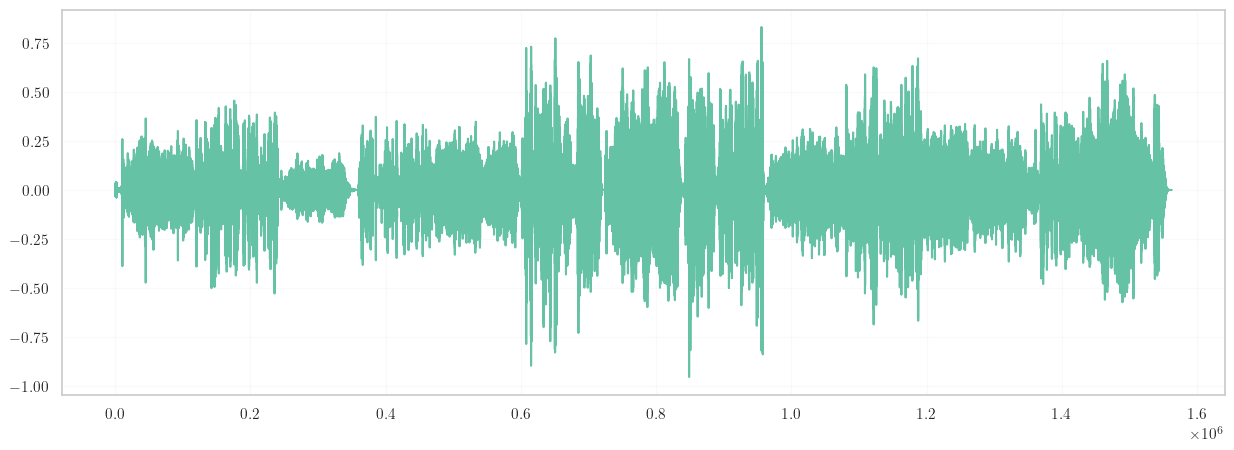

In [18]:
plt.figure(figsize=(15, 5))
plt.plot(x)
plt.show()

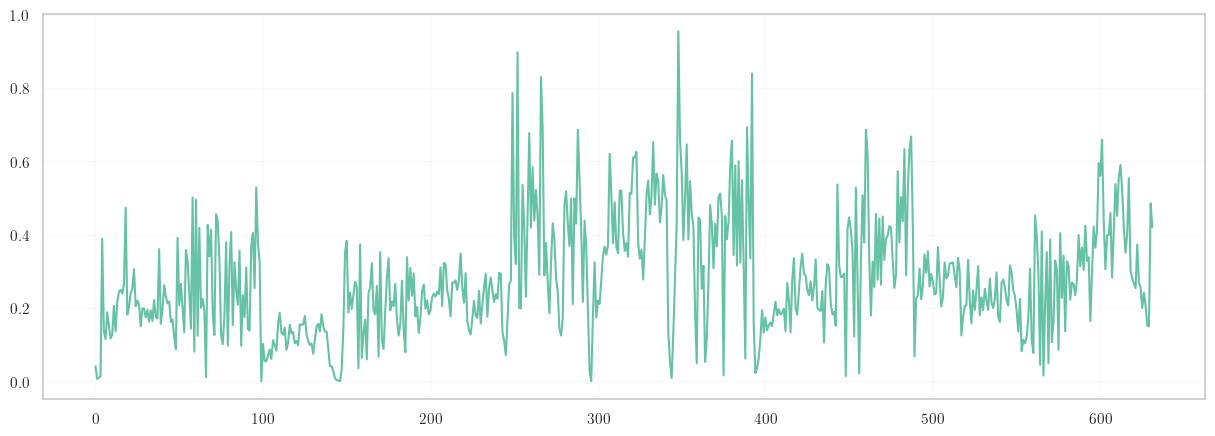

In [20]:
plt.figure(figsize=(15, 5))
plt.plot(X_truncated)
plt.show()

In [19]:
X_truncated.shape

(632,)

In [21]:
Y_truncated.shape

(632, 163840)

In [22]:
np.concatenate((Y_truncated[:, 0].reshape(632,1), X_truncated.reshape(632,1)), axis=-1)

array([[0.        , 0.04033458],
       [0.        , 0.00615622],
       [0.        , 0.00973471],
       ...,
       [0.        , 0.14960846],
       [0.        , 0.48506245],
       [0.        , 0.42015922]])

In [102]:
from statsmodels.tsa.stattools import grangercausalitytests as grangertest

In [24]:
results = []
indexes = []
sz = 163840
for i in tqdm(range(sz)):
    try:
        results.append(grangertest(np.concatenate((Y_truncated[:, i].reshape(632,1), X_truncated.reshape(632,1)), axis=-1), maxlag=4, verbose=False))
        indexes.append(i)
    except:
        pass

  0%|          | 0/163840 [00:00<?, ?it/s]

In [34]:
significant_pvalues = []
significant_indexes = []

for i in range(len(results)):
    if results[i][4][0]['ssr_ftest'][1] < 0.03:
        significant_pvalues.append(results[i][4][0]['ssr_ftest'][1])
        significant_indexes.append(indexes[i])

In [35]:
Y.shape

(641, 163840)

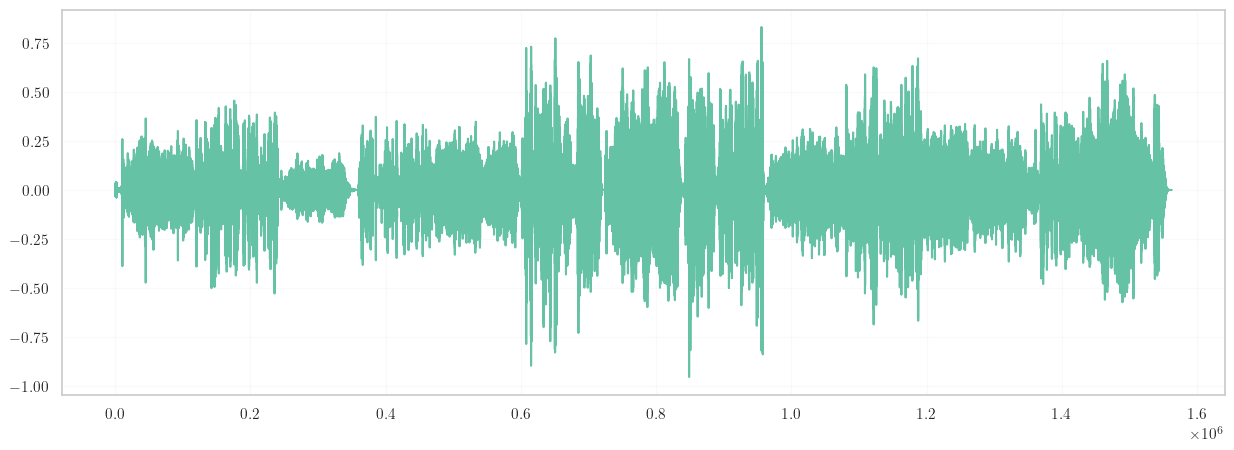

In [36]:
plt.figure(figsize=(15, 5))
plt.plot(x)
plt.show()

In [37]:
iii = np.argmin(significant_pvalues)

In [38]:
len(significant_indexes)

1943

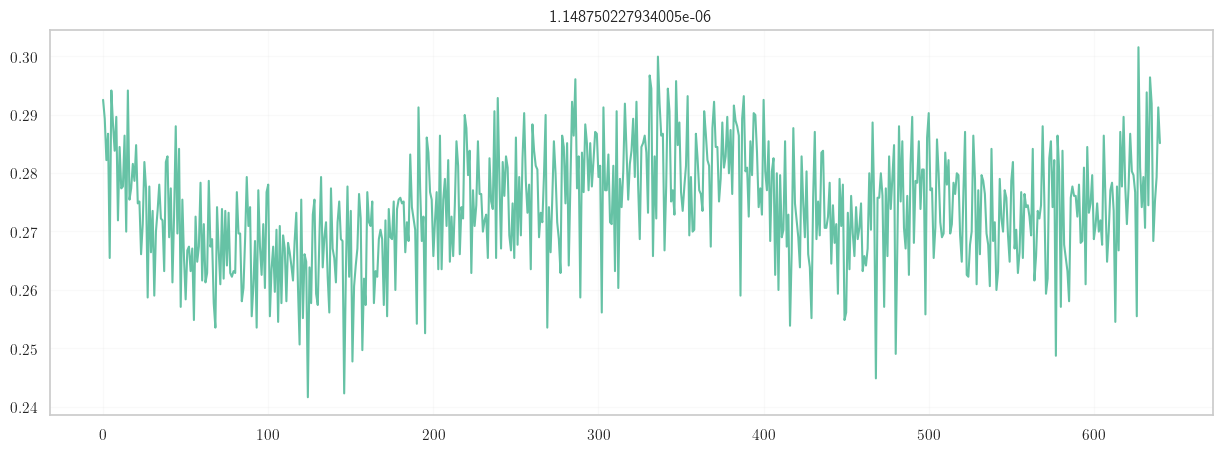

In [39]:
plt.figure(figsize=(15, 5))
plt.plot(Y[:, significant_indexes[iii]])
plt.title(significant_pvalues[iii])
plt.show()

In [10]:
x, sr = librosa.load(os.path.join(os.getcwd(), "src", "Film stimulus.mp3"), sr=4000)

In [40]:
pvals = np.zeros((40 * 64 * 64))
pvals[significant_indexes] = 1

In [30]:
pvals.shape

(163840,)

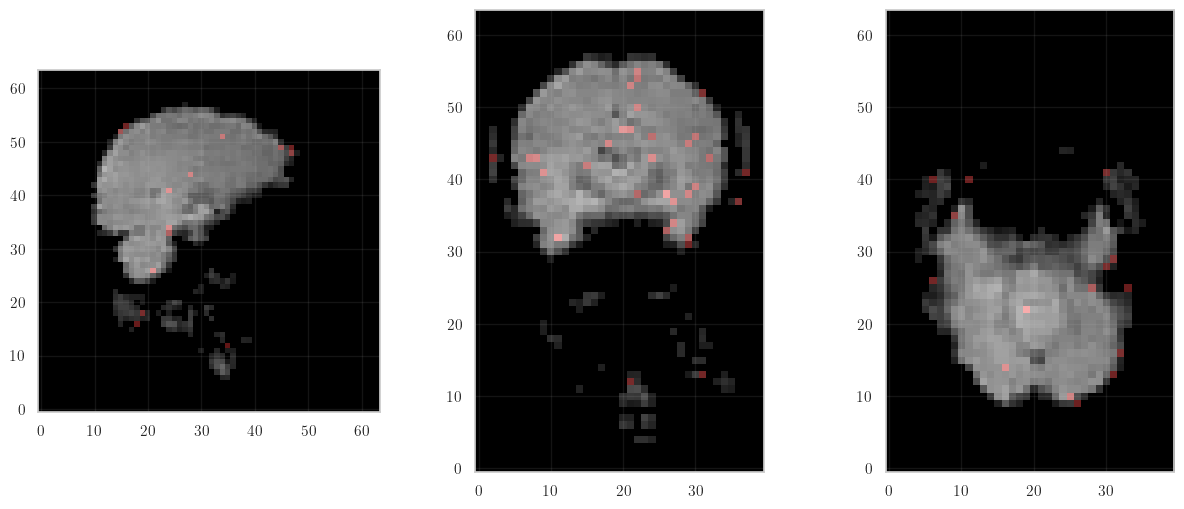

In [31]:
plt.figure(figsize=(15, 6))
cmap = colors.ListedColormap(['black', 'red'])

plt.subplot(1, 3, 1)
plt.imshow(sub.normalized[3][14, :, :].T, cmap='gray', origin='lower')
plt.imshow((pvals > 0.4).reshape(40, 64, 64)[14, :, :].T, cmap=cmap, origin="lower", alpha=0.3)

plt.subplot(1, 3, 2)
plt.imshow(sub.normalized[3][:, 30, :].T, cmap='gray', origin="lower")
plt.imshow((pvals > 0.4).reshape(40, 64, 64)[:, 30, :].T, cmap=cmap, origin="lower", alpha=0.3)

plt.subplot(1, 3, 3)
plt.imshow(sub.normalized[3][:, :, 35].T, cmap='gray', origin="lower")
plt.imshow((pvals > 0.4).reshape(40, 64, 64)[:, :, 35].T, cmap=cmap, origin="lower", alpha=0.3)